Средний купон:  7.52
Ст отклонение купона:  3.17
Средняя доходность последней сделки:  11.59
Ст отклонение доходности последней сделки:  4.0
Средняя цена:  85.79
Ст отклонение средней цены:  14.22
НКД по всем выпускам:  1138038659.89
Общий долг:  8289232005.0


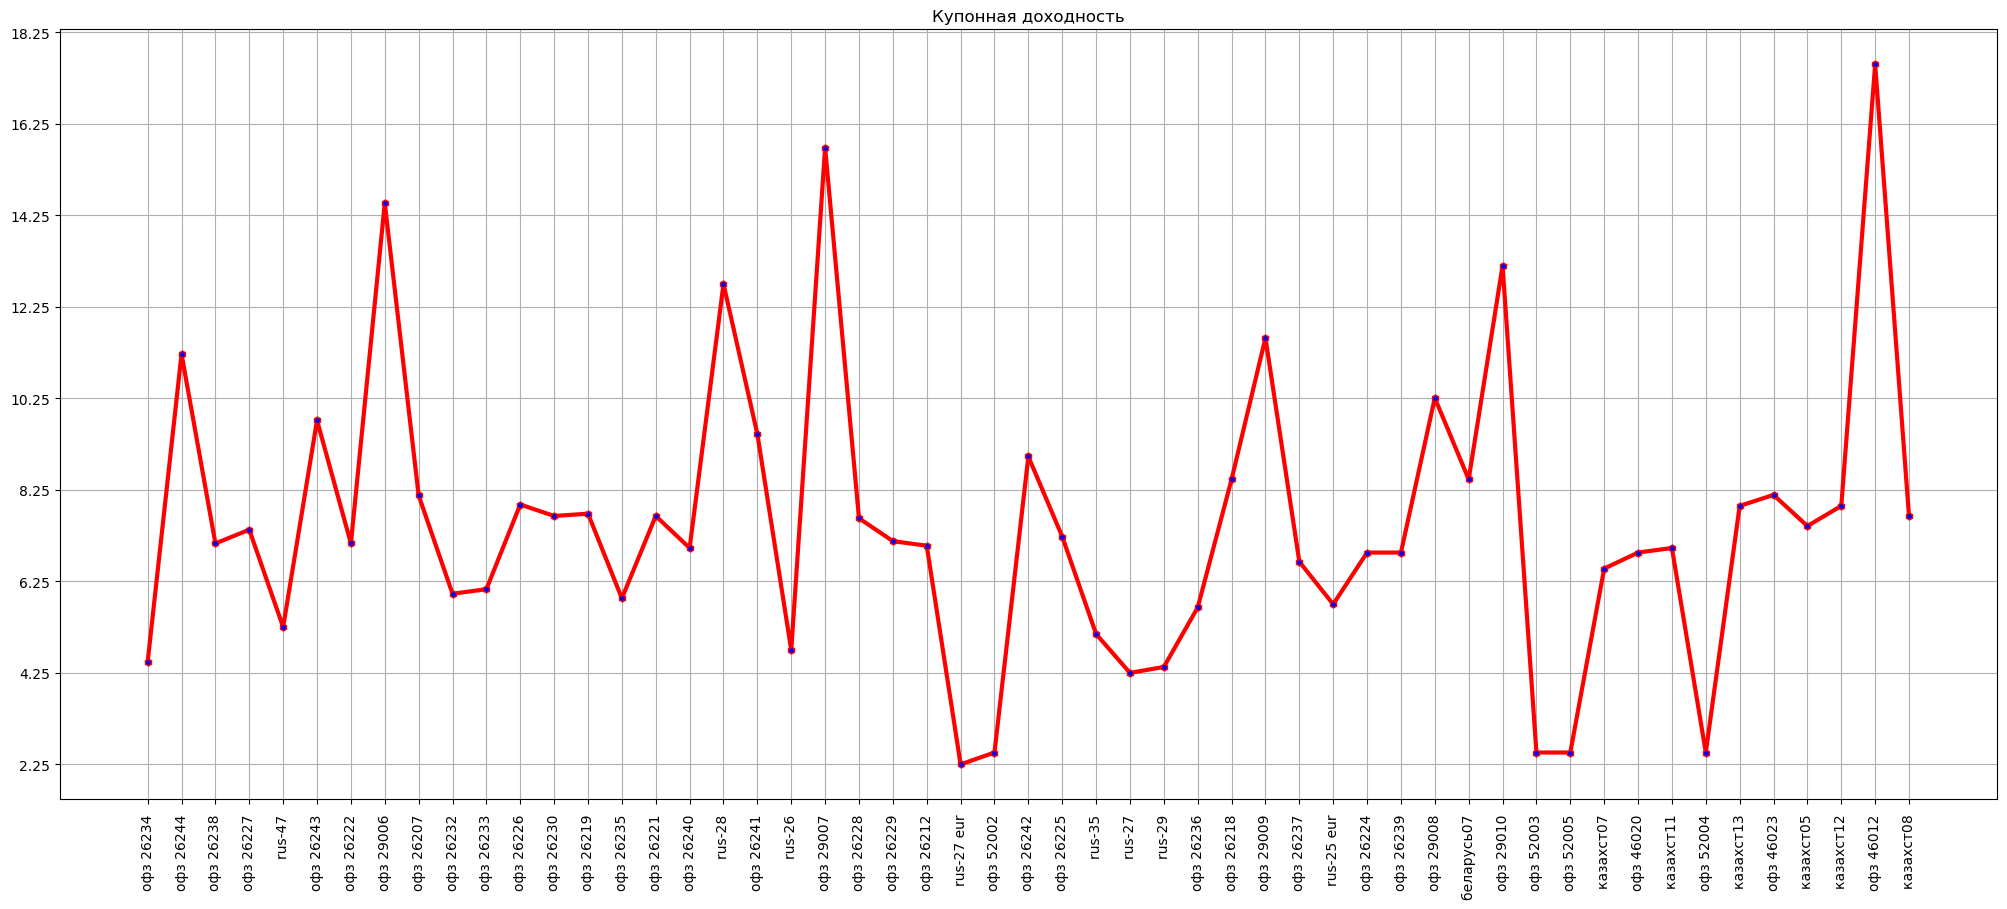

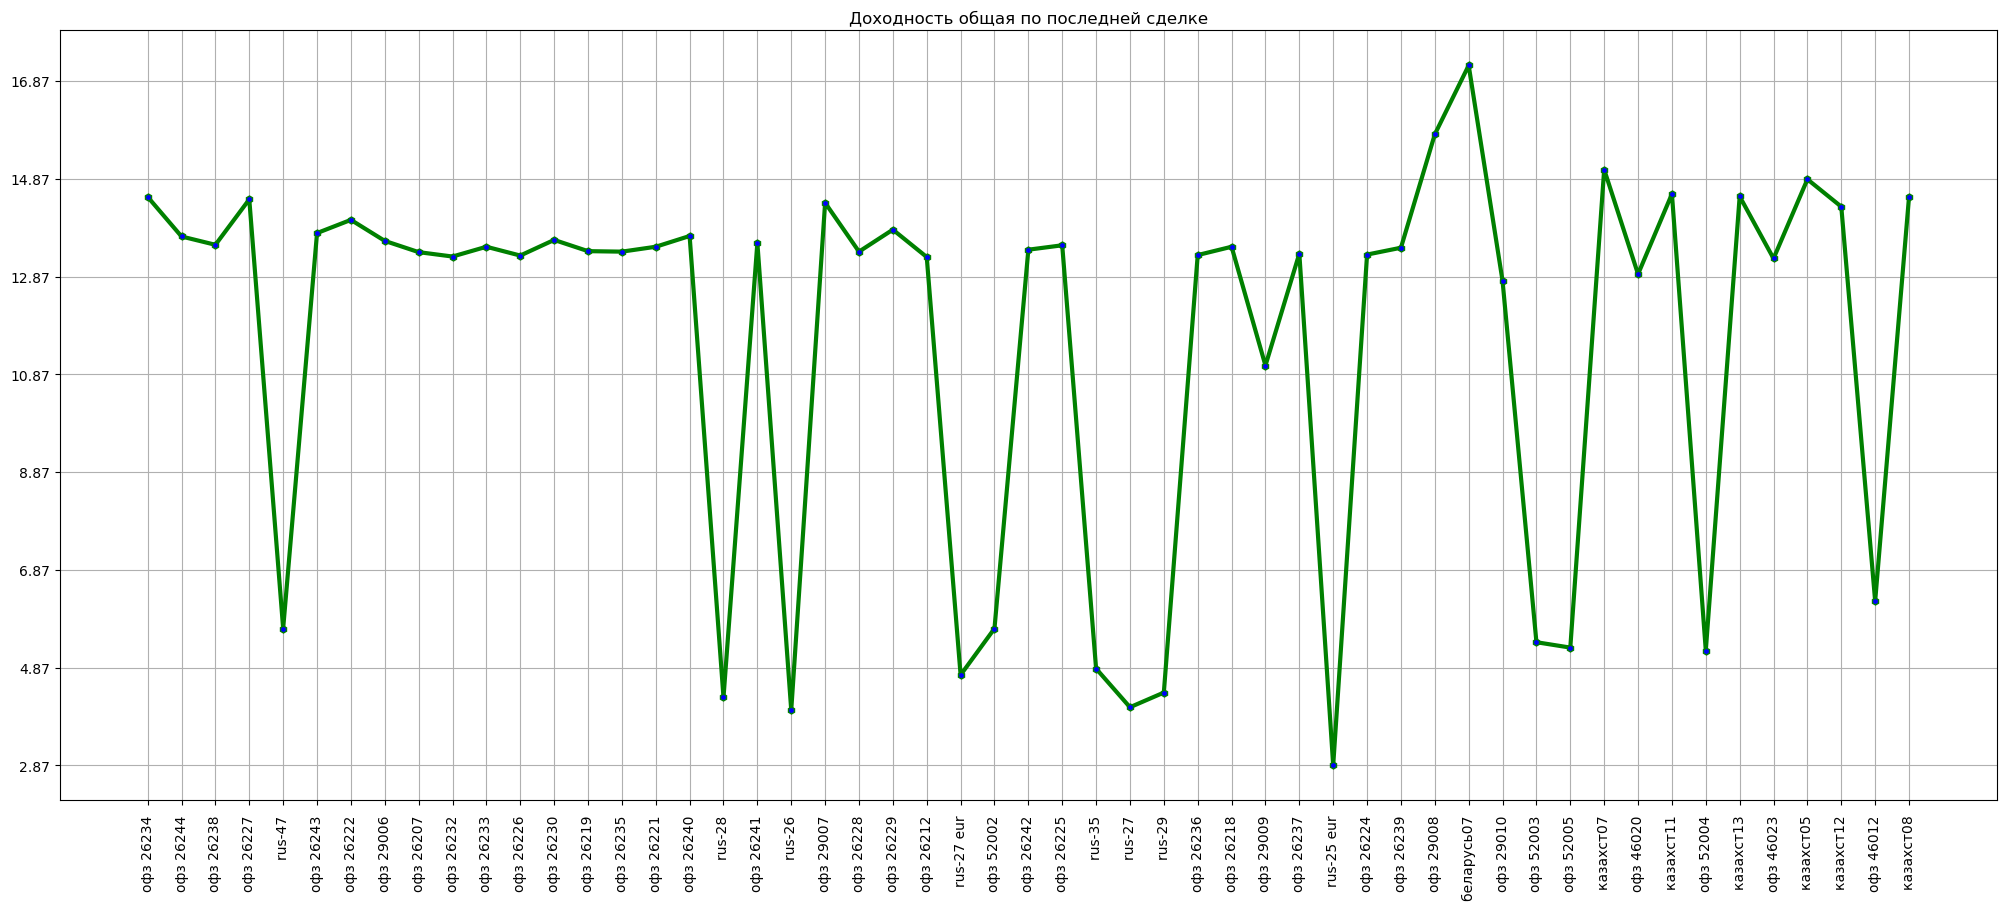

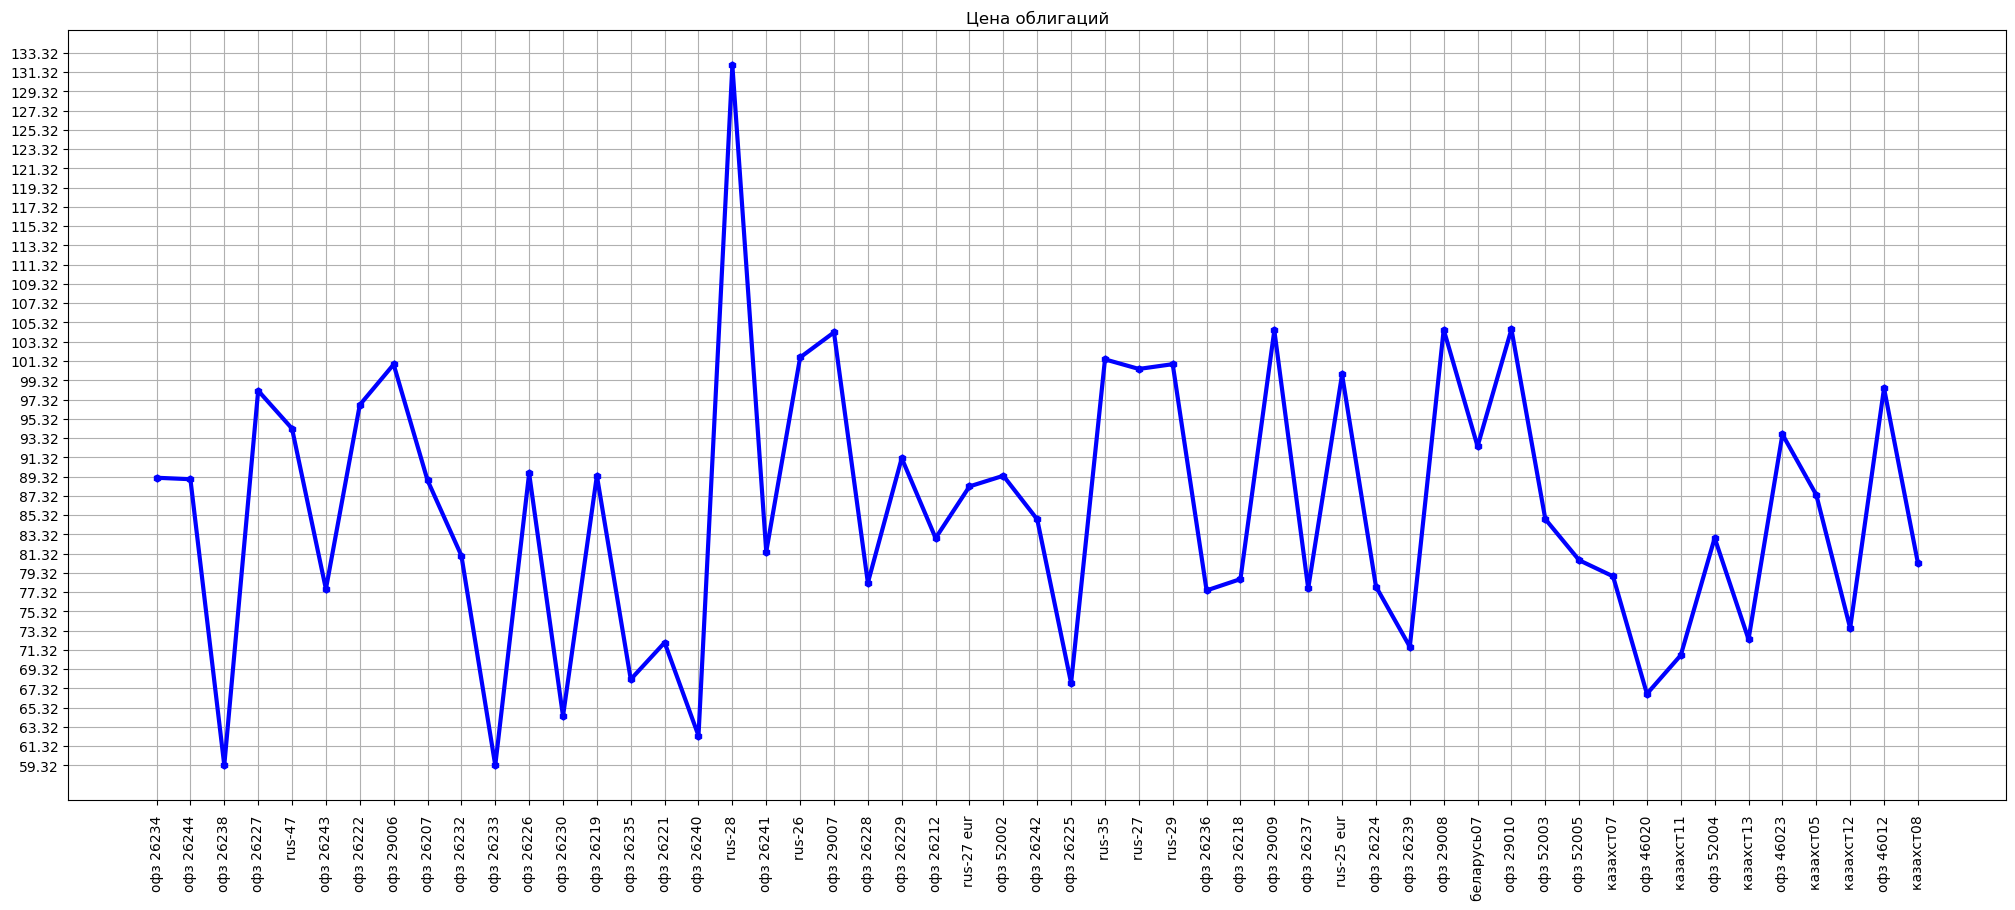

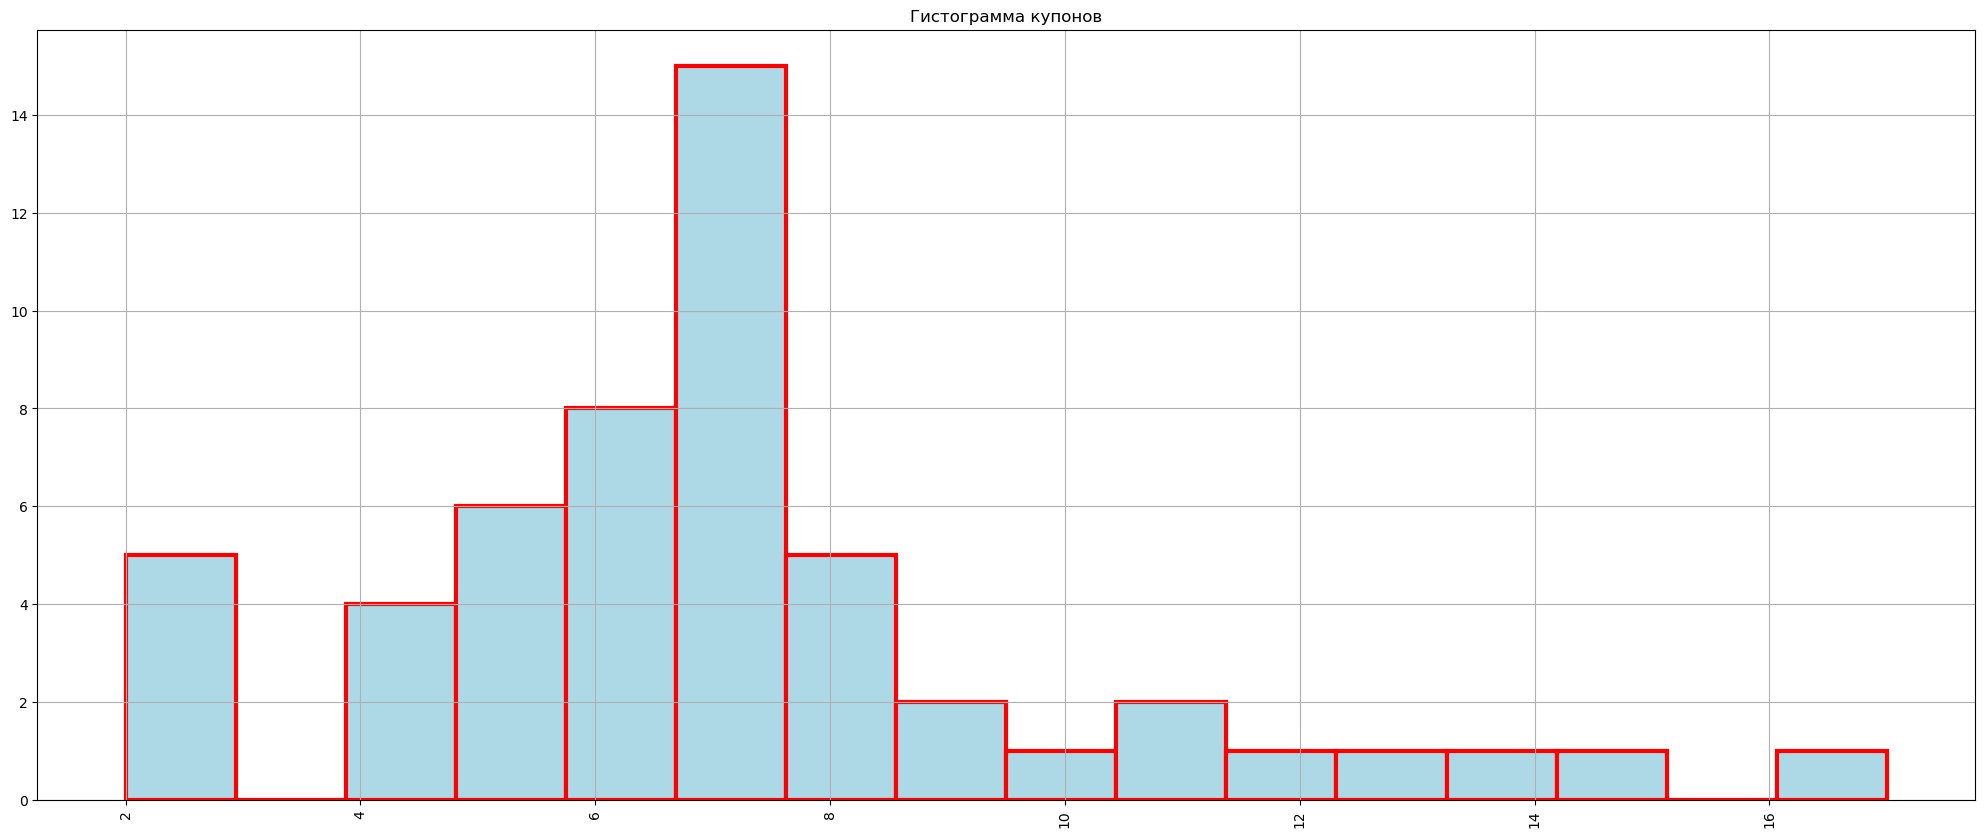

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import statistics

data = pd.read_csv('ofz.csv', encoding='Windows-1251', decimal=',')
#названия столбцов в нижний формат, пробелы заменяем _, точки заменяем на пустой символ
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '')

#приводим к удобному формату:
#переводим в нижний формат
data['код'] = data['код'].str.lower()
data['наименование'] = data['наименование'].str.lower()
data['валюта_номинала'] = data['валюта_номинала'].str.lower()
data['валюта_расчетов'] = data['валюта_расчетов'].str.lower()

#некоторые значения суммы купона в сырых данных пропущены, заменяем на 0
data['сумма_купона'] = data['сумма_купона'].str.replace('-', '0')
#приводим к float сумму купона, непогашенный долг, чтобы заполнить столбец ставка_купона
data['сумма_купона'] = data['сумма_купона'].str.replace(',', '.').astype(float)
data['непогашенный_долг'] = data['непогашенный_долг'].astype(float)
#заполняем столбец ставка_купона и переводим в проценты и в строку
data['ставка_купона'] = round(((data['сумма_купона'].astype(float) / data['непогашенный_долг'].astype(float) * 2) * 100), 2)

#убрали все бумаги, у которых нет рыночной цены
data['цена_%_средневзвешенная'] = data['цена_%_средневзвешенная'].str.replace('-', '0')
data['цена_%_средневзвешенная'] = data['цена_%_средневзвешенная'].str.replace(',', '.').astype(float)
data = data.loc[data['цена_%_средневзвешенная'].astype(float) > 0]


#выводим очищенные данные в файл и отрисовываем статистики на графиках
#дополнительно считаем статистики
###################################################################################
#убираем бумаги, у которых доходность последней сделки отрицательная или выше 2-х стандартных отклонений
#убираем бумаги, у которых средневзвешенная цена отрицательная или выше 2-х стандартных отклонений
data['дох_посл_сделки'] = data['дох_посл_сделки'].str.replace('-', '0')
data['дох_посл_сделки'] = data['дох_посл_сделки'].str.replace(',', '.').astype(float)
data['нкд'] = data['нкд'].astype(str)
data['нкд'] = data['нкд'].str.replace(',', '.')
data['нкд'] = data['нкд'].str.replace('-', '0')
data['нкд'] = data['нкд'].astype(float)

stde_interest = statistics.stdev(data['ставка_купона'])
average_interest = statistics.mean(data['ставка_купона'])
stde_doh_last = statistics.stdev(data['дох_посл_сделки'])
average_doh_last = statistics.mean(data['дох_посл_сделки'])
stde_price = statistics.stdev(data['цена_%_средневзвешенная'])
average_price = statistics.mean(data['цена_%_средневзвешенная'])

data = data.loc[data['дох_посл_сделки'].astype(float) <= ((stde_doh_last * 2) + average_doh_last)]
data = data.loc[data['дох_посл_сделки'].astype(float) > 0]
data = data.loc[data['цена_%_средневзвешенная'].astype(float) <= ((stde_price * 2) + average_price)]
data = data.loc[data['цена_%_средневзвешенная'].astype(float) > 0]

stde_interest = statistics.stdev(data['ставка_купона'])
average_interest = statistics.mean(data['ставка_купона'])
stde_doh_last = statistics.stdev(data['дох_посл_сделки'])
average_doh_last = statistics.mean(data['дох_посл_сделки'])
stde_price = statistics.stdev(data['цена_%_средневзвешенная'])
average_price = statistics.mean(data['цена_%_средневзвешенная'])
sum_nkd = (data['объем_в_валюте'].astype(float) / data['непогашенный_долг'].astype(float) * data['нкд']).sum(axis = 0)
#sum_nkd = data['нкд'].sum(axis = 0)
sum_debt = data['объем_в_валюте'].astype(float).sum(axis = 0)

print("Средний купон: ", round(average_interest, 2))
print("Ст отклонение купона: ", round(stde_interest, 2))
print("Средняя доходность последней сделки: ", round(average_doh_last, 2))
print("Ст отклонение доходности последней сделки: ", round(stde_doh_last, 2))
print("Средняя цена: ", round(average_price, 2))
print("Ст отклонение средней цены: ", round(stde_price, 2))
print("НКД по всем выпускам: ", round(sum_nkd, 2))
print("Общий долг: ", sum_debt)

###################################################################################

data.to_csv('ofz_cleared.csv')
#отрисовываем график купонной доходности
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data['ставка_купона']), max(data['ставка_купона'])+2, 2.0))
ax.set_title("Купонная доходность")
ax.plot(data['наименование'],data['ставка_купона'], '-rh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('kupon_ofz.png')
plt.show()
#отрисовываем график общей доходности
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data['дох_посл_сделки']), max(data['дох_посл_сделки'])+2, 2.0))
ax.set_title("Доходность общая по последней сделке")
ax.plot(data['наименование'],data['дох_посл_сделки'], '-gh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('dohod_eff_ofz.png')
plt.show()
#отрисовываем график цен бумаг
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
plt.yticks(np.arange(min(data['цена_%_средневзвешенная']), max(data['цена_%_средневзвешенная'])+2, 2.0))
ax.set_title("Цена облигаций")
ax.plot(data['наименование'],data['цена_%_средневзвешенная'], '-bh', linewidth=3, markersize=5, markerfacecolor='b')
ax.grid()
plt.savefig('price_ofz.png')
plt.show()

#отрисовываем частоту купонов
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1)
plt.xticks(rotation="vertical")
ax.set_title("Гистограмма купонов")
ax.hist(data['ставка_купона'].astype(int),16,linewidth = 3, color = "lightblue", ec="red")
ax.grid()
plt.savefig('interest_distribution.png')
plt.show()

